In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

import qiskit as qs
from qiskit import Aer
from qiskit.circuit.library import MCMT
from qiskit.tools.visualization import plot_histogram

We want to generate the matrix for $U_{neigh}$ for a n-bit string in terms of basic transformations. It is a diagonal matrix, with 1s where the strings don't match and -1s where they do match.

We imagine we have to registeries which are made of qubit strings of same size n.

In [2]:
def binstr(i):
    "Given an int 'i', returns the corresponding binary string"
    return '{0:b}'.format(i)

In [3]:
def unpackbits(x, num_bits):
    """
    Converts an array of integers to arrays of binary representation, whose
    length adapts 
    
    x = array of integers to convert to binary
    num_bits = number of bits needed (i.e. number of bits of largest integer)
    
    source: https://stackoverflow.com/questions/18296035/how-to-extract-the-bits-of-larger-numeric-numpy-data-types
    """
    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])
    
    unpackedbits = (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])
    
    # had to add this myself as it gives the flipped version of what I am looking for
    return np.flip(unpackedbits, axis=1)



In [4]:
def U_neigh_diag(n):
    """Returns the elements on the diagonal of U_neigh
    
    n: size of the binary strings to compare, A and B.
    """
    mat_size = 2**(2*n) # size of the corresponding matrix needed to represent U_neigh

    # get array of indices as integers (shape = (n, 1))
    mat_indices = np.indices((mat_size,))[0]

    # convert to binary string format
    mat_indices_binary = unpackbits(mat_indices, 2*n)

    # split into the string corresponding to string A and that corresponding to string B
    indices_stringA, indices_stringB = mat_indices_binary[:, :n], mat_indices_binary[:, n:]

    # convert to a Boolean array that indicates when A and B are exactly equal or not
    equal_strings = np.all(indices_stringA == indices_stringB, axis=1)

    # converts to an array of -1s and 1s, where we have -1 when A = B and 1 otherwise.
    mat_diag = -2*(equal_strings - 0.5)
    
    return mat_diag

# n = 4
# mat_diag = U_neigh_diag(n)

In [5]:
n = 1 # size of the binary strings to compare
mat_size = 2**(2*n) # size of the corresponding matrix needed to represent U_neigh

# get array of indices as integers (shape = (n, 1))
mat_indices = np.indices((mat_size,))[0]

# convert to binary string format
mat_indices_binary = unpackbits(mat_indices, 2*n)

# split into the string corresponding to string A and that corresponding to string B
indices_stringA, indices_stringB = mat_indices_binary[:, :n], mat_indices_binary[:, n:]

# convert to a Boolean array that indicates when A and B are exactly equal or not
equal_strings = np.all(indices_stringA == indices_stringB, axis=1)

# converts to an array of -1s and 1s, where we have -1 when A = B and 1 otherwise.
mat_diag = -2*(equal_strings - 0.5)

In [6]:
matches = np.where(mat_diag == -1.0)[0]
matches_count = matches.shape[0]
print(f"For n={n}, we get {matches_count} string matches between A and B.")

For n=1, we get 2 string matches between A and B.


We find that for comparison of n-bit strings, there are $2^n$ matches. This is as expected since there are 2^n possible n-bit strings and that the matrix covers all possible combinations for both strings A and B.

In [7]:
np.unique(np.diff(matches))[0] == 2**n + 1

True

The matches occur at regular intervals with a period of $2^n + 1$.

## Building the transformation



In [8]:
def equal_gate():
    """
    Equivalent to the XNOR gate.
    
    Qubits 0 and 1 are input,
    Qubit 2 is the output. It is flipped if inputs are equal, left unchanged otherwise.
    
    (a, b, c) -> (a, b, c + ~(a + b))
    """
    circ = qs.QuantumCircuit(3, name="EQUAL")
    circ.cx(0, 2)
    circ.cx(1, 2)
    circ.x(2)
    
    return circ.to_gate()

def multi_and_gate(num_ctrl):
    """
    Equivalent to a n-Controlled NOT gate.
    
    num_ctrl is the number of control qubits.
    
    Qubit 0 is the target, and qubits 1 to n are the control.
    
    (b, a_1, a_2, ..., a_n) -> (b + a_1^a_2^...a_n, a_1, a_2, ..., a_n)
    """
    
    circ = MCMT("x", num_ctrl_qubits=num_ctrl, num_target_qubits=1)
    return circ.to_gate(label="AND")

def f_gate(n):
    """
    Returns instructions for the gate which implements function f,
    the function at the center of U_neigh
    
    n is the length of the input binary strings, a and b.
    
    This gate requires 3n + 1 qubits.
    """
    input_a = qs.QuantumRegister(n, name="in_a")
    input_b = qs.QuantumRegister(n, name="in_b")
    anc = qs.QuantumRegister(n, name="ancilla")
    output = qs.QuantumRegister(1, name="out")

    f = qs.QuantumCircuit(input_a, input_b, anc, output, name="F")
    for i in range(n):
        f.append(equal_gate(), [input_a[i], input_b[i], anc[i]])
    f.append(multi_and_gate(n), anc[:]+output[:])

    return f.to_gate()

In [13]:
a = qs.QuantumRegister(n, name="in_a")

In [18]:
a[:]

[Qubit(QuantumRegister(2, 'in_a'), 0), Qubit(QuantumRegister(2, 'in_a'), 1)]

In [9]:
# Developing a systematic test for f_gate

def classical_f(a, b):
    if len(a) != len(b):
        raise Exception("Input lengths must be the same.")
    
    # Computing whether each bit is equal
    anc = ""
    for i in range(len(a)):
        anc += "1" if a[i] == b[i] else "0"
    
    # Making output equal if all anc are 1 (i.e. if all bits were equal)
    out = "1" if anc == len(anc)*"1" else "0"
    
    final_state = a+b+anc+out
    final_state = final_state[::-1]# must be reversed to match Qiskit syntax
    
    return final_state

def quantum_f(a, b):
    
    if len(a) != len(b):
            raise Exception("Input lengths must be the same.")
    n = len(a)

    input_a = qs.QuantumRegister(n, name="in_a")
    input_b = qs.QuantumRegister(n, name="in_b")
    anc = qs.QuantumRegister(n, name="ancilla")
    output = qs.QuantumRegister(1, name="out")
    circ = qs.QuantumCircuit(input_a, input_b, anc, output)

    # making reversed arrays as strings (must be reversed to match Qiskit convention)
    a_str = ''.join(str(x) for x in a[::-1])
    b_str = ''.join(str(x) for x in b[::-1])

    # Initializing the input states
    circ.initialize(a_str, input_a)
    circ.initialize(b_str, input_b)

    # Adding the f gate
    circ.append(f_gate(n), qargs=list(range(circ.num_qubits)))

    # Adding measurements of all qubits
    circ.measure_all()

    print(circ)

    # Running the circuit
    simulator = Aer.get_backend('qasm_simulator')
    result = qs.execute(circ, backend = simulator).result()
    counts = result.get_counts()
    outputs = list(counts.keys())

    if len(outputs) > 1:
        raise Exception("More than 1 result obtained")

    return outputs[0]

def gen_string(n):
    return "".join(random.choice("01") for _ in range(n))

In [10]:
n = 2
a = gen_string(n)
b = gen_string(n)

cl_out = classical_f(a, b)
qu_out = quantum_f(a, b)

print(f"a={a} and b={b}")
print(f"Classical output is {cl_out}")
print(f"Quantum output is {qu_out}")
print(f"Are they same? {cl_out==qu_out}")

           ┌──────────────────┐┌────┐ ░ ┌─┐                  
   in_a_0: ┤0                 ├┤0   ├─░─┤M├──────────────────
           │  Initialize(0,0) ││    │ ░ └╥┘┌─┐               
   in_a_1: ┤1                 ├┤1   ├─░──╫─┤M├───────────────
           ├──────────────────┤│    │ ░  ║ └╥┘┌─┐            
   in_b_0: ┤0                 ├┤2   ├─░──╫──╫─┤M├────────────
           │  Initialize(0,1) ││    │ ░  ║  ║ └╥┘┌─┐         
   in_b_1: ┤1                 ├┤3 F ├─░──╫──╫──╫─┤M├─────────
           └──────────────────┘│    │ ░  ║  ║  ║ └╥┘┌─┐      
ancilla_0: ────────────────────┤4   ├─░──╫──╫──╫──╫─┤M├──────
                               │    │ ░  ║  ║  ║  ║ └╥┘┌─┐   
ancilla_1: ────────────────────┤5   ├─░──╫──╫──╫──╫──╫─┤M├───
                               │    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐
      out: ────────────────────┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├
                               └────┘ ░  ║  ║  ║  ║  ║  ║ └╥┘
   meas: 7/══════════════════════════════╩══╩══╩══╩══╩══╩══╩═
        

In [11]:
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

NameError: name 'counts' is not defined

Now your job is to build U from f. Design a check that shows you that you do obtain the transformation matrix that you are looking for. See how you can get U given that you have auxillary qubits, and hence you will need 1st to obtain the gloibal phase of your state (to check whether you have that -1) and 2nd to obtain a sort of reduced matrix that only looks at the transformation of inputs a and b concatenated (and removes the auc), otherwise you will have a much larger matrix than desired.

Plan:
Build the phase kickback scenario, try it for n=1 with a superposition of |a>|b> = (|0>+|1>)(|0>+|1>) and see whether you have relative phases of -1 between them.

Problem: it's very difficult to measure relative phase. I would need to build an entirely new circuit.

In [19]:
def equal_coeffs(n_qbits):
    """
    Returns an array of the coefficients for an equal normalized superposition 
    of all possible states of an n-qubit system.
    """
    n_states = 2**n_qbits
    coeff = 1/np.sqrt(n_states)
    coeffs = [coeff]*n_states
    
    return np.array(coeffs)

In [20]:
str_len = 1

input_a = qs.QuantumRegister(str_len, name="in_a")
input_b = qs.QuantumRegister(str_len, name="in_b")
anc = qs.QuantumRegister(str_len, name="ancilla")
output = qs.QuantumRegister(1, name="out")
q_registers = (input_a, input_b, anc, output)

mes_output = qs.ClassicalRegister(1)
cl_registers = (mes_output,)

circ = qs.QuantumCircuit(*q_registers)

# Initializing the input states to equal superpositons of possible input strings for a and b
coeffs = equal_coeffs(str_len)
circ.initialize(coeffs, input_a)
circ.initialize(coeffs, input_b)

# Initializing the output qubit to |-> for phasekickback
circ.initialize([1/np.sqrt(2), -1/np.sqrt(2)], output)

# Adding the f gate
circ.append(f_gate(str_len), qargs=list(range(circ.num_qubits)))

# Adding measurements of qubits of a and b qubits
# circ.measure(output, mes_output)
# circ.measure_all()

print(circ)

# Running the circuit
# simulator = Aer.get_backend('qasm_simulator')
# result = qs.execute(circ, backend = simulator).result()
# counts = result.get_counts()
# plot_histogram(counts)

# # Statevector simulation method
# sim_statevector = Aer.get_backend('aer_simulator_statevector')
# job_statevector = sim_statevector.run(circ)
# counts_statevector = job_statevector.result().get_counts(0)

         ┌─────────────────────────────┐ ┌────┐
   in_a: ┤ Initialize(0.70711,0.70711) ├─┤0   ├
         ├─────────────────────────────┤ │    │
   in_b: ┤ Initialize(0.70711,0.70711) ├─┤1   ├
         └─────────────────────────────┘ │  F │
ancilla: ────────────────────────────────┤2   ├
         ┌──────────────────────────────┐│    │
    out: ┤ Initialize(0.70711,-0.70711) ├┤3   ├
         └──────────────────────────────┘└────┘


In [17]:
f_gate(str_len)

Instruction(name='F', num_qubits=4, num_clbits=0, params=[])

In [36]:
# from https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html
# Let's see the result
svsim = Aer.get_backend('aer_simulator')
circ.save_statevector(label="sv")
# qobj = qs.assemble(circ)
qobj = qs.transpile(circ, svsim)
# qobj = qs.assemble(test)
final_state = svsim.run(qobj).result().data()["sv"]

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit.visualization import array_to_latex
array_to_latex(final_state, prefix="\\text{Statevector} = ")

# Create a Qobj from the circuit for the simulator to run
# test = transpile(circuit, svsim)
# qobj = assemble(test)

# # Do the simulation, return the result and get the state vector
# result = svsim.run(qobj).result().get_statevector()

<IPython.core.display.Latex object>

In [37]:
final_state

Statevector([ 0.        +0.j,  0.35355339+0.j,  0.35355339+0.j,
              0.        +0.j, -0.35355339+0.j, -0.        +0.j,
             -0.        +0.j, -0.35355339+0.j, -0.        +0.j,
             -0.35355339+0.j, -0.35355339+0.j, -0.        +0.j,
              0.35355339+0.j,  0.        +0.j,  0.        +0.j,
              0.35355339+0.j],
            dims=(2, 2, 2, 2))


In [20]:
qc = qs.QuantumCircuit(3)
# Apply H-gate to each qubit:
for qubit in range(3):
    qc.h(qubit)
# See the circuit:
qc.draw()
# Let's see the result
svsim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = qs.assemble(qc)
final_state = svsim.run(qobj).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit.visualization import array_to_latex
array_to_latex(final_state, prefix="\\text{Statevector} = ")

<IPython.core.display.Latex object>

In [ ]:
def init_equal_superposition():

In [739]:
from qiskit.quantum_info import random_statevector
state = random_statevector(4)
state.data

array([ 0.47565721-0.24398564j, -0.64844009+0.17332364j,
        0.13694174-0.46666333j,  0.11662289-0.11652034j])

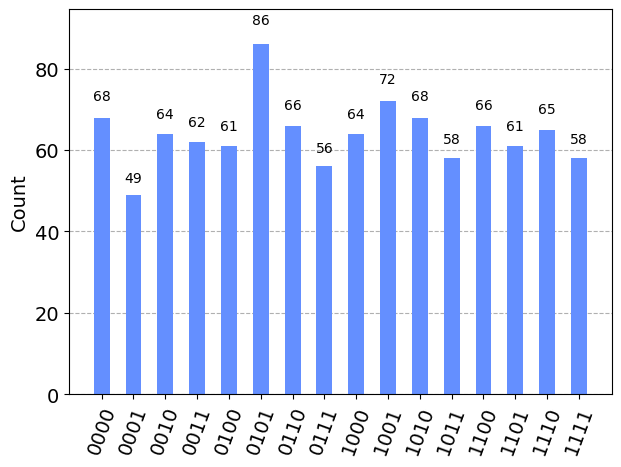

In [760]:
n_qbits = 4
qbit_indices = list(range(n_qbits))
qc = qs.QuantumCircuit(n_qbits)
qc.initialize(equal_coeffs(n_qbits), qbit_indices)
qc.measure_all()
qc.draw()
simulator = Aer.get_backend('qasm_simulator')
result = qs.execute(qc, backend = simulator).result()
counts = result.get_counts()
plot_histogram(counts)

To determine relative phase of states is complicated. This stackoverflow thingy suggests a way: https://physics.stackexchange.com/questions/261664/how-to-measure-relative-phases-of-quantum-states 

Next step:
- Make progress on your latex thingy,
- Find out precisely what a diffuser is, what it would look like in your case, and how it would be implemented as a gate.

https://www.cs.cmu.edu/~odonnell/quantum15/lecture04.pdf

The diffusion operator it seems is the equal superposition of all the matches. 

That is, 


On the qiskit website they say it is the equal superopositon of the initial state https://qiskit.org/textbook/ch-algorithms/grover.html



In [ ]:
# from https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html
# Let's see the result
svsim = Aer.get_backend('aer_simulator')
qc.save_statevector()
qobj = assemble(qc)
final_state = svsim.run(qobj).result().get_statevector()

# In Jupyter Notebooks we can display this nicely using Latex.
# If not using Jupyter Notebooks you may need to remove the 
# array_to_latex function and use print(final_state) instead.
from qiskit.visualization import array_to_latex
array_to_latex(final_state, prefix="\\text{Statevector} = ")

WHAT WOULD HELP FOR THE TEST OR IN GENERAL IS a function that maps a state e.g. "0010" to its index in the statevector representation. Then I can generate what I'm expecting the statevector to look like if my algorithm worked properly.